## RISEI - Randomized Input Sampling for Explanations with Inpainting

In [1]:
import os
import cv2

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.transform import resize

from pathos.multiprocessing import ProcessPool
from multiprocessing import Pool

from tensorflow.keras import preprocessing

from PIL import Image

In [80]:
def generate_mask(params):
    grid = params['grid']
    options = params['options']
    i = params['i']
    image_data = params['image_data']
    
    shift_x, shift_y = __get_random_shift(options)

    mask = __get_mask(options, grid, shift_x, shift_y)
    binary_mask = __get_binary_mask(options, grid, shift_x, shift_y)
    inpaint_mask = __get_inpaint_mask(options, image_data, binary_mask)
    new_image = __merge(options, image, mask, inpaint_mask)

    cache = None
    # when the debug mode is enabled
    # save the generated images to cache
    if options['debug']:
        cache = {
            'grid': grid,
            'mask': mask,
            'binary_mask': binary_mask,
            'inpaint_mask': inpaint_mask,
        }

    return i, new_image, cache

def __merge(options, original_image, mask, inpaint_mask):
    # convert inpaint mask from array to image so we can blend it
    inpaint_image = Image.fromarray(inpaint_mask.astype(np.uint8), 'RGB')

    # blend original image with inpaint mask and convert it to array
    new_image = np.array(Image.blend(original_image, inpaint_image, alpha=options['b1']))

    # blend original image with inpaint mask with mask
    new_image = new_image * (1 - ((1 - mask.reshape((*options['input_size'], 1))) * options['b2']))

    return new_image


def __get_inpaint_mask(options, image_data, binary_mask):
    # we need to invert our binary mask, since ones stands for
    # locations to be inpainted in cv2.inpaint algorithm
    return cv2.inpaint(
        image_data,
        1 - binary_mask.astype(np.uint8),
        options['inpaint_radius'],
        options['inpaint_algorithm']
    )


def __get_random_shift(options):
    shift_x = np.random.randint(0, options['over_image_size'][0])
    shift_y = np.random.randint(0, options['over_image_size'][1])

    return shift_x, shift_y


def __get_mask(options, grid, shift_x, shift_y):
    return resize(grid,
                  options['mask_size'],
                  order=1,
                  mode='reflect',
                  anti_aliasing=False)[shift_y:shift_y + options['input_size'][0], shift_x:shift_x + options['input_size'][1]]


def __get_binary_mask(options, grid, shift_x, shift_y):
    new_grid = np.zeros(options['mask_size'])

    for y in range(0, new_grid.shape[0]):
        for x in range(0, new_grid.shape[1]):
            grid_y = int(y // options['cell_size'][0])
            grid_x = int(x // options['cell_size'][1])

            new_grid[y][x] = grid[grid_y][grid_x]

    return new_grid[shift_y:input_size[0] + shift_y, shift_x:input_size[1] + shift_x]


class RISEI():
    def __init__(self, input_size, **kwargs):
        self.options = {
            'input_size': input_size,
            's': kwargs.get('s', 8),  # size of the "grid" - binary mask
            'p1': kwargs.get('p1', 0.5),  # probability of cell being white - transparent
            'b1': kwargs.get('b1', 0.8),  # inpaint mask blend
            'b2': kwargs.get('b2', 0.5),  # black mask blend
            'inpaint_radius': kwargs.get('inpaint_radius', 20),  # inpainting radius
            'inpaint_algorithm': kwargs.get('inpaint_algorithm', cv2.INPAINT_TELEA),
            # cv2.INPAINT_TELEA, cv2.INPAINT_NS
            'debug': kwargs.get('debug', False),
            'mask_size': None,
            'cell_size': None,
            'over_image_size': None,
            'processes': kwargs.get('processes', 4),
        }

        self.cache = None

        self.__get_grid_size()

    def generate_masks(self, N, image):
        self.__initialize_cache(N, image)

        image_data = np.array(image).astype(np.uint8)

        grids = self.__get_empty_grids(N)
        images_data = self.__get_empty_images_data(N)

        process_pool = Pool(processes=options['processes'])
        params = [{ 'i': i, 'options': self.options, 'grid': grids[i], 'image_data': image_data } for i in range(0, N)]

        with process_pool as p:
            with tqdm(desc='Generating masks', total=N) as pbar:
                for i, new_image, cache in p.imap_unordered(generate_mask, params):
                    images_data[i, :, :, :] = new_image

                    if cache is not None:
                        self.__save_to_cache(i, new_image, cache)

                    pbar.update()

        return images_data

    def show_from_last_run(self, i, figsize=(12, 8), ncols=3, nrows=2):
        original_image = self.show_image_from_last_run(i)
        mask = self.show_mask_from_last_run(i)
        binary_mask = self.show_binary_mask_from_last_run(i)
        inpaint = self.show_inpaint_from_last_run(i)
        result = self.show_result_from_last_run(i)

        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        ax = axes.ravel()

        ax[0].set_title('Original')
        ax[0].imshow(original_image)

        ax[1].set_title('Binary mask')
        ax[1].imshow(binary_mask)

        ax[2].set_title('Mask')
        ax[2].imshow(mask)

        ax[3].set_title('Inpaint')
        ax[3].imshow(inpaint)

        ax[4].set_title('Result')
        ax[4].imshow(result)

        for a in ax:
            a.axis('off')

        fig.tight_layout()
        plt.show()

    def show_mask_from_last_run(self, i):
        mask = self.__get_from_cache('masks', i)
        w, h = self.options['input_size']

        image = 255 * np.ones((h, w, 3), dtype=np.uint8)
        new_image = image * mask.reshape((*self.options['input_size'], 1))

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_binary_mask_from_last_run(self, i):
        binary_mask = self.__get_from_cache('binary_masks', i)
        w, h = self.options['input_size']

        image = 255 * np.ones((h, w, 3), dtype=np.uint8)
        new_image = image * binary_mask.reshape((*self.options['input_size'], 1))

        return Image.fromarray(new_image.astype(np.uint8), 'RGB')

    def show_image_from_last_run(self, i):
        return image

    def show_inpaint_from_last_run(self, i):
        inpaint_mask = self.__get_from_cache('inpaint_masks', i)
        return Image.fromarray(inpaint_mask.astype(np.uint8), 'RGB')

    def show_result_from_last_run(self, i):
        image_data = self.__get_from_cache('images_data', i)
        return Image.fromarray(image_data.astype(np.uint8), 'RGB')

    def __get_from_cache(self, key, i):
        if self.cache == None:
            raise Exception('Cache is not defined! Initialize algorithm with debug=True')
        if len(self.cache[key]) <= i:
            raise Exception(f'Index {i} does not exist!')
        return self.cache[key][i]

    def __save_to_cache(self, i, image_data, cache):
        self.cache['images_data'][i, :, :, :] = image_data
        self.cache['grids'][i, :, :] = cache['grid']
        self.cache['masks'][i, :, :] = cache['mask']
        self.cache['binary_masks'][i, :, :] = cache['binary_mask']
        self.cache['inpaint_masks'][i, :, :, :] = cache['inpaint_mask']

    def __initialize_cache(self, N, image):
        if self.options['debug']:
            self.cache = {
                'image': image,
                'images_data': np.empty((N, *self.options['input_size'], 3)),
                'grids': np.empty((N, self.options['s'], self.options['s'])),
                'masks': np.empty((N, *self.options['input_size'])),
                'binary_masks': np.empty((N, *self.options['input_size'])),
                'inpaint_masks': np.empty((N, *self.options['input_size'], 3)),
            }
        else:
            self.cache = None
            
    def __get_empty_grids(self, N):
        grids = np.random.rand(N, self.options['s'], self.options['s']) < self.options['p1']
        return grids.astype('float32')

    def __get_empty_images_data(self, N):
        return np.empty((N, *self.options['input_size'], 3))
    
    def __get_grid_size(self):
        # the size of one pixel (rectangle)
        cell_size = np.ceil(np.array(input_size) / self.options['s'])

        # the additional size for each rectangle
        # since we do a crop from the mask, we
        # need to make a "bigger" mask
        # we calculate how much we need to increase the cell
        # to increase the current size by one additional cell
        over_cell_size = np.ceil((((self.options['s'] + 1) * cell_size) - (self.options['s'] * cell_size)) / self.options['s'])

        # new cell size
        new_cell_size = cell_size + over_cell_size

        # mask size (mask is larger than the image)
        mask_size = (self.options['s'] * new_cell_size).astype(np.uint32)

        # difference in size between original image and mask
        over_image_size = mask_size - input_size

        self.options['mask_size'] = mask_size
        self.options['cell_size'] = new_cell_size
        self.options['over_image_size'] = over_image_size

In [8]:
def load_image(path, input_size):
    img = preprocessing.image.load_img(path, target_size=input_size)
    return img

Generating masks:   0%|          | 0/10 [00:00<?, ?it/s]


(10, 300, 300, 3)


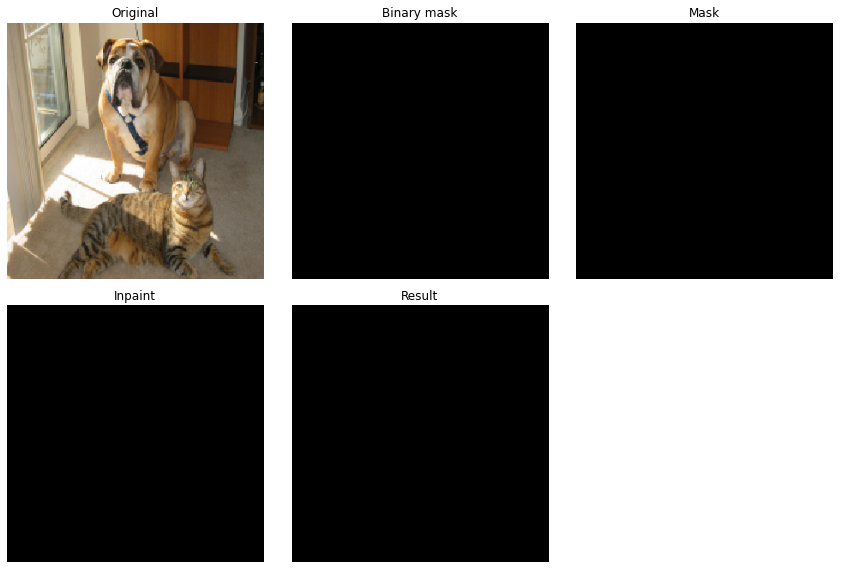

CPU times: user 780 ms, sys: 323 ms, total: 1.1 s
Wall time: 1.47 s


In [18]:
%%time

input_size = [300, 300]
image = load_image('../data/catdog.png', input_size)

risei = RISEI(input_size, s=8, p1=0.5, b1=0.75, b2=0.75, inpaint_radius=5, debug=True)

masks = risei.generate_masks(10, image)

print(masks.shape)

risei.show_from_last_run(0)

Generating masks: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


(1, 630, 630, 3)


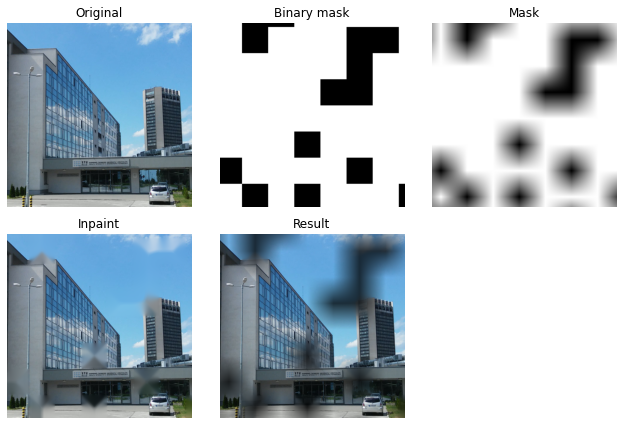

CPU times: user 677 ms, sys: 122 ms, total: 799 ms
Wall time: 5.87 s


In [72]:
%%time

input_size = [630, 630]
image = load_image('../data/fiit.jpg', input_size)

risei = RISEI(input_size, s=8, p1=0.75, b1=0.75, b2=0.75, inpaint_radius=15, debug=True)

masks = risei.generate_masks(1, image)

print(masks.shape)

risei.show_from_last_run(0, figsize=(9, 6))

In [85]:
%%time

from pathos.multiprocessing import ProcessPool

input_size = [630, 630]
image = load_image('../data/fiit.jpg', input_size)
print(image)

risei = RISEI(input_size, s=8, p1=0.75, b1=0.75, b2=0.75, inpaint_radius=5, processes=4, debug=False)

masks = risei.generate_masks(100, image)

print(masks.shape)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=630x630 at 0x1411FD8D0>


Generating masks: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]

(100, 630, 630, 3)
CPU times: user 993 ms, sys: 1.58 s, total: 2.58 s
Wall time: 1min 7s


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=630x630 at 0x1411DE090>


Generating masks: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


(100, 630, 630, 3)


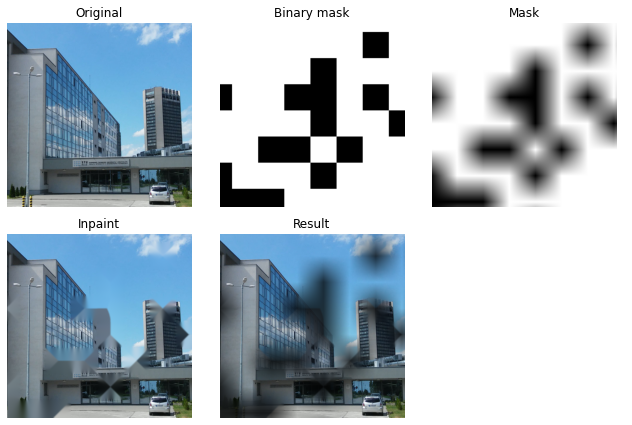

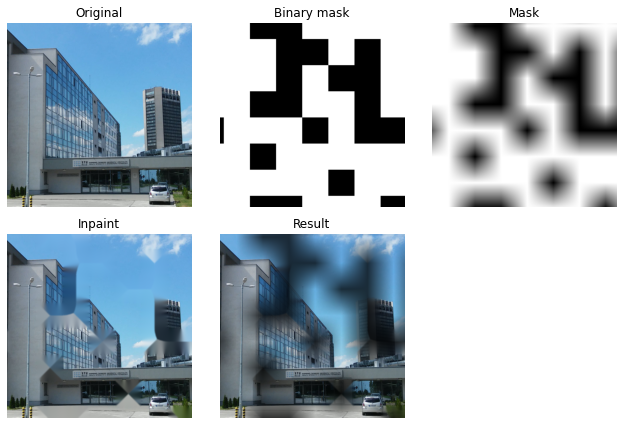

CPU times: user 3.6 s, sys: 3.52 s, total: 7.12 s
Wall time: 1min 10s


In [84]:
%%time

from pathos.multiprocessing import ProcessPool

input_size = [630, 630]
image = load_image('../data/fiit.jpg', input_size)
print(image)

risei = RISEI(input_size, s=8, p1=0.75, b1=0.75, b2=0.75, inpaint_radius=5, processes=4, debug=True)

masks = risei.generate_masks(100, image)

print(masks.shape)

risei.show_from_last_run(0, figsize=(9, 6))
risei.show_from_last_run(15, figsize=(9, 6))